## AD Channel 

Applied Bell state, U0, Ansatz and training 
Ansatz - Realamplitude 
Optimizer - COBYLA



In [1]:
import numpy as np
%matplotlib inline
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

import matplotlib.pyplot as plt


from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import sqrtm, eig
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import *
from qiskit import *
import numpy as np
import math
from qiskit.quantum_info import concurrence, state_fidelity, average_gate_fidelity, process_fidelity, Statevector
import matplotlib.pyplot as plt
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import sqrtm, eig
from sympy import symbols, sqrt
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
import sympy
algorithm_globals.random_seed = 42

In [2]:
data = pd.read_csv('u0-dataset.csv')

data['true_label']=data['concurrence'].apply(lambda x: 0 if x == 0 else 1)

In [3]:
data

,time,gamma,concurrence,true_label
0,0.00,0.001,1.0000,1
1,0.25,0.001,1.0000,1
2,0.50,0.001,1.0000,1
3,0.75,0.001,0.9995,1
4,1.00,0.001,0.9995,1
...,...,...,...,...
795,198.75,0.001,0.0000,0
796,199.00,0.001,0.0000,0
797,199.25,0.001,0.0000,0
798,199.50,0.001,0.0000,0


In [4]:
data_features = data.iloc[:, 0:2]
data_labels = data.iloc[:,3].values

In [5]:
#data_labels

In [6]:
X = data_features
y = data_labels

In [7]:
X

,time,gamma
0,0.00,0.001
1,0.25,0.001
2,0.50,0.001
3,0.75,0.001
4,1.00,0.001
...,...,...
795,198.75,0.001
796,199.00,0.001
797,199.25,0.001
798,199.50,0.001


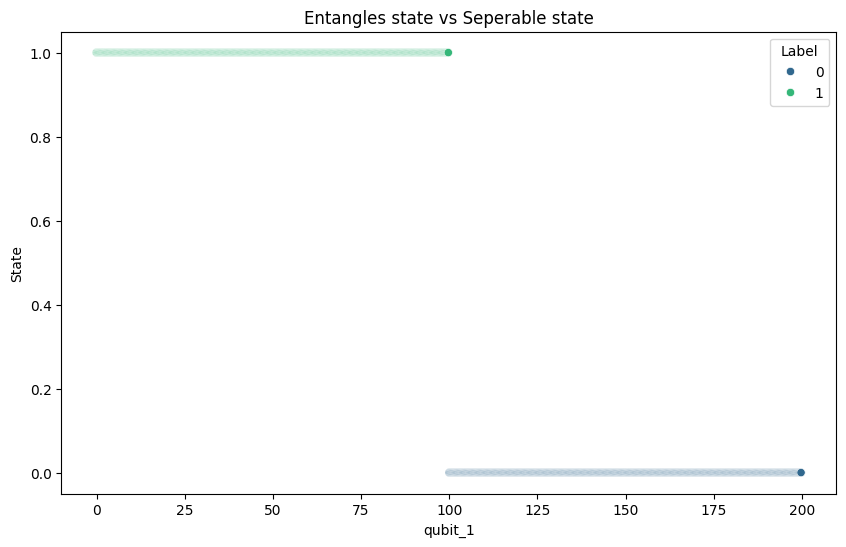

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time', y='true_label', hue='true_label', palette='viridis', data=data)
plt.title('Entangles state vs Seperable state')
plt.xlabel('qubit_1')
plt.ylabel('State')
plt.legend(title='Label')
plt.show()

In [9]:
num_qubits=X.shape
num_qubits

(800, 2)

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate


class UHGate(Gate):
    def __init__(self, x,y, label=None):
        super().__init__('U', 2, [x,y], label=label)
        
        
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.unitary_mat_0()[0], [0, 1])

        self.definition = qc

    
    def kraus_list(self,gamma,t):
        nf= np.exp(-gamma*t)
        k1=[[1,0],[0,np.sqrt(nf)]]
        k2=[[0,np.sqrt(1-nf)],[0,0]]
        return k1,k2
    


    def unitary_mat_0(self):
        gamma = self.params[0]
        t = self.params[1]
        k_list=self.kraus_list(gamma,t)
        k0=np.array(k_list[0])
        k1=np.array(k_list[1])
        D0=sqrtm(np.identity(2)-np.matmul(k0.T.conjugate(),k0))
        D0dag=sqrtm(np.identity(2)-np.matmul(k0,k0.T.conjugate()))
        D1=sqrtm(np.identity(2)-np.matmul(k1.T.conjugate(),k1))
        D1dag=sqrtm(np.identity(2)-np.matmul(k1,k1.T.conjugate()))

        z=np.array([[1,0],[0,-1]])
        x=np.array([[0,1],[1,0]])
        y=np.array([[0,-1j],[1j,0]])

        u0= np.kron((x-1j*y)/2,D0)+ np.kron((x+1j*y)/2,D0dag)+np.kron((np.identity(2)+z)/2,k0)-np.kron((np.identity(2)-z)/2,k0.T.conjugate())
        u1= np.kron((x-1j*y)/2,D1)+ np.kron((x+1j*y)/2,D1dag)+np.kron((np.identity(2)+z)/2,k1)-np.kron((np.identity(2)-z)/2,k1.T.conjugate())


        return u0,u1
# t = Parameter('θ')
# qc = QuantumCircuit(2)
# qc.append(UHGate(t), [0, 1])

num_qubits = 2
feature_map=QuantumCircuit(2)
feature_map.h(0)
feature_map.cx(0,1)
x,y = Parameter('x'),Parameter('y')
mat = UHGate(x,y)
# x[0], x[1] = symbols('t gamma')
#  x[0],x[1] = symbols('x[0] x[1]')
feature_map.append(UHGate(x,y),[0,1])
feature_map.draw()



┌───┐     ┌─────────┐
q_0: ┤ H ├──■──┤0        ├
     └───┘┌─┴─┐│  U(x,y) │
q_1: ─────┤ X ├┤1        ├
          └───┘└─────────┘

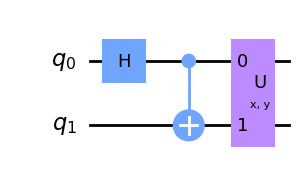

In [11]:
feature_map.draw(output='mpl',style="clifford")

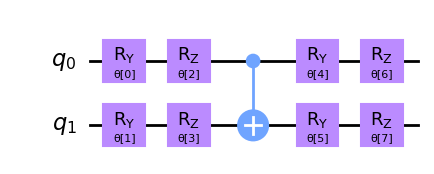

In [12]:
from qiskit.circuit.library import RealAmplitudes,EfficientSU2,NLocal,TwoLocal
from qiskit.circuit.library import NLocal, CXGate, CRZGate, RXGate
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

ansatz = EfficientSU2(num_qubits=2, reps=1)
ansatz.decompose().draw(output="mpl", style="clifford", fold=50)


In [13]:
model=QuantumCircuit(2,2)
model.append(feature_map,[0,1])
model.append(ansatz,[0,1])

# model.decompose().decompose().draw("mpl", style="clifford")

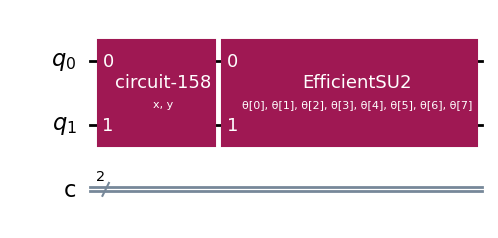

In [14]:
model.draw('mpl')

In [15]:
ansatz.measure_all()

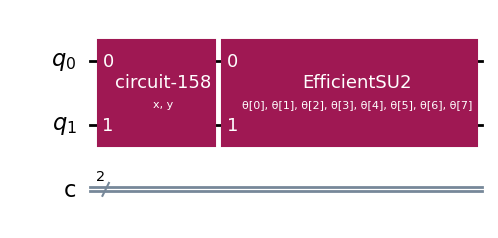

In [16]:
model.draw('mpl')

In [17]:
# para = np.array([ 1.05336414, -0.09110876,  3.89126788,  0.81768431,  0.50504381,
#         0.85062235])

In [18]:
from qiskit.primitives import StatevectorSampler
from scipy.special import rel_entr

In [19]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(ansatz.parameters):
        parameters[p] = variational[i]
#     print(parameters)
#     print(model.parameters)
    return model.assign_parameters(parameters)

In [20]:
data_features = data_features.to_numpy()

In [21]:
from qiskit.quantum_info import random_unitary
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import DensityMatrix
from qiskit_algorithms.state_fidelities import base_state_fidelity
from qiskit.visualization import plot_state_qsphere
import matplotlib.pyplot as plt
from scipy import integrate
from qiskit_algorithms.gradients import ParamShiftSamplerGradient

In [22]:
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1/len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
grad = []
fidelity = []
variances = []
def calculate_kl_divergence(train_features, variational):
#         """Calculate KL divergence for the dataset."""
#     train_features = train_features.to_numpy()
    variational = [variational]
#     print(model.num_parameters)
        
    sampler = Sampler()
    gradient = ParamShiftSamplerGradient(sampler)

#     print(variational)
    pss_grad_result = gradient.run(ansatz, variational).result().gradients
    pss = list(pss_grad_result[-1][-1].values())
    grad.append(pss)
#     print("State sampler gradient computed with parameter shift", pss_grad_result)
    variances.append(np.var(pss))
    return variances

In [23]:
from qiskit_algorithms.optimizers import COBYLA,AQGD,SPSA

optimizer = COBYLA(maxiter=100)

from qiskit.primitives import Sampler

sampler = Sampler()
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (6, 6)

kl = []
weights_all = []
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    global kl
    kl.clear()
    clear_output(wait=True)
    global objective_func_vals
    objective_func_vals.append(obj_func_eval)
    global weights_all
    weights_all.append(weights)
#     print("weights",weights_all)
    kl_t = calculate_kl_divergence(train_features,weights)
    
    kl.append(kl_t)
#     accuracy_t = calculate_accuracy(weights)
#     accuracy.appned(accuracy_t)
#     plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals,label='cost')
#     ax2.plot(range(len(kl)), kl_t, label='kl')
#     plt.plot(range(len(objective_func_vals)), accuracy,label='accuracy')
    plt.savefig("2qubit_loss_iteration_ESU.png")
    plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42

train_features, val_features, train_labels, val_labels = train_test_split(
    data_features, data_labels, test_size=0.2, random_state=42
)

In [25]:
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    plt.title("Objective function")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(counts)), mean)
    plt.show()

In [26]:
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss,L2Loss

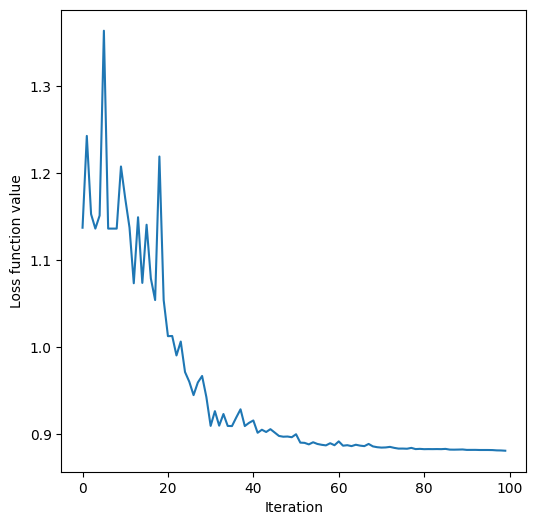

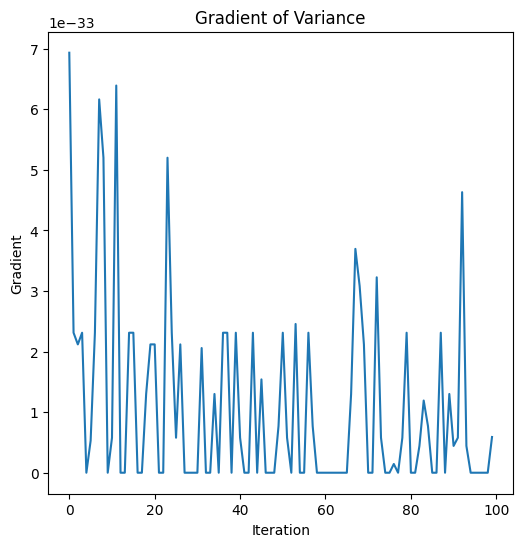

In [27]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

# Training loop over epochs

#     plt.plot(range(len(objective_func_vals)), kl,label='kl')
#     plt.plot(range(len(objective_func_vals)), accuracy,label='accuracy')
plt.show()
    # Fit the model
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

# Predict on training and validation data
train_predictions = vqc.predict(train_features)
val_predictions = vqc.predict(val_features)

# gradient_csv = pd.DataFrame(kl[0])
# gradient_csv.to_csv("gradient_dataESU10.csv")
obj_ESU_2qcsv = pd.DataFrame(objective_func_vals)
obj_ESU_2qcsv.to_csv("objective_func_vals_ESU_2q.csv")
# plt.title("Gradient of Variance")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient")
# x = np.arange(len(kl[0]))
# plt.plot(x, kl[0],label='cost')




In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [29]:
print(classification_report(val_labels,val_predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        80
           1       1.00      0.94      0.97        80

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



In [30]:
confusion_matrix = confusion_matrix(val_labels, val_predictions)
print('Confusion Matrix:')
print(confusion_matrix)

Confusion Matrix:
[[80  0]
 [ 5 75]]
